In [497]:
import logging
import pickle
import torch
import pandas as pd
import tensorflow as tf
from waymo_open_dataset import dataset_pb2
from waymo_open_dataset.utils import keypoint_data
from waymo_open_dataset.protos import keypoint_pb2
import io
import PIL
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import collections as mc
from waymo_open_dataset.utils.keypoint_draw import Wireframe

from waymo_open_dataset.utils import keypoint_draw
JOINT_KEYS = {1: 0, 5: 1,
              6: 2, 7: 3, 8: 4,
              9: 5, 10: 6, 13: 7,
              14: 8, 15: 9, 16: 10,
              17: 11, 18: 12, 20: 13,
              }
REVERSE_JOINT_KEYS = {value: key for key, value in JOINT_KEYS.items()}

plt.rcParams['figure.dpi'] = 800
plt.rcParams['savefig.dpi'] = 800





In [405]:
# only draw with one color for better vis
OCCLUDED_BORDER_WIDTH = 3


def draw_camera_wireframe(ax, wireframe, zorders, alpha, color=None) -> None:
    """Draws a camera wireframe onto the axes."""
    if color is not None:
        facecolors = [color for d in wireframe.dots]
        colors = [color for l in wireframe.lines]
        edgecolors = [color for d in wireframe.dots]
    else:
        facecolors = [d.color for d in wireframe.dots]
        colors = [l.color for l in wireframe.lines]
        edgecolors = [d.actual_border_color for d in wireframe.dots],
    dots_sizes = [d.size for d in wireframe.dots]
    ax.add_collection(
        mc.EllipseCollection(
            widths=dots_sizes,
            heights=dots_sizes,
            angles=0,
            alpha=alpha,
            zorder=zorders[1],
            units='xy',
            offsets=[d.location for d in wireframe.dots],
            facecolors=facecolors,
            edgecolors=edgecolors,
            linewidth=1,
            transOffset=ax.transData,
            antialiased=True))
    ax.add_collection(
        mc.LineCollection(
            segments=[[l.start, l.end] for l in wireframe.lines],
            colors=colors,
            alpha=alpha,
            zorder=zorders[1],
            linewidths=[l.width for l in wireframe.lines],
            antialiased=True))

    print(wireframe.dots)


In [406]:
labels = "/media/petbau/data/waymo/v0.10/alpha_pose/labels.pkl"

image_segment_relations = pd.read_csv("/media/petbau/data/waymo/v0.10/alpha_pose/image_segment_relations.csv")


In [407]:

logging.info(f'Loading labels from {labels}...')
with open(labels, 'rb') as pickle_file:
    labels = pickle.load(pickle_file)

In [483]:
#id = "80_2_l1jmpmqm9n1c71YymDLv1Q"
#id = "131_1_KiLv-hRicxRgRM6NGLL8rw"
#id = "158_1_kO9Df1WTlSDyiH_PAibaGA"
#id = "159_1__77TG6zk8fi0Io4JRWXH8w"
#id = '34_4_sLOFERaK6UJrBrdJj7jhyQ'
id = '135_3_JG6d8lgj_SM2BrdlC2ryeg' # -> used for thesis
#id = '109_4_Kj83jG1FL0sIqQoDH5vM9Q'
#id = '52_3_uopyvjrwTJ4mQIva3AMfgQ'
#id = '29_5_XYzk0zuuRn7UDCLQO4gKHA' <- Failure Case
#id = '75_3_a0W7w3x0q0Hlf9zZSTgTjQ'
#id = '42_3_B16I3pS-bNr-LqvpePtvew'
id = "182_2_pjHqgXW1mxalSuScBsLIUA"# -> presi
#id = "157_5_1Uu4TyWyXgVwgTsqlldMxg"# -> presi
#id = "38_2__4M0K1JMzrjBTmrnDT5vpg" # -> presi
#id = "53_4_pXQUHK8VM_QpLLlP4hzkJw" # -> presi
#id = "141_2_1ToyAlzNaSN7ZKB-QCP-Yw"
id = "80_2_l1jmpmqm9n1c71YymDLv1Q"
#id = "192_3_5_p9gdOFB3sY9TTI7ZmXCA"

id = "66_3_B7YV3XwQtG0zoKhERaw7dw" # -> Use tghis


margin = 0.3

In [484]:
#labels[id]['cp_points'][:, 1:]

In [485]:

keypoints = labels[id]['keypoints_2d_arr_un'][:, :2].copy()
occlusions_scores = labels[id]['keypoints_2d_arr_un'][:, -1]
crop_width = (1 + margin) * labels[id]['bb_2d']['width']
crop_height = (1 + margin) * labels[id]['bb_2d']['height']
min_x = max(0, labels[id]['bb_2d']['center_x'] - crop_width/2)
min_y = max(0, labels[id]['bb_2d']['center_y'] - crop_height/2)

keypoints[:, 0] = keypoints[:, 0] - min_x
keypoints[:, 1] = keypoints[:, 1] - min_y

ap_cropped_keypoints = []
counter = 0
for keypoint, occlusion in zip(keypoints, occlusions_scores):
    cam_keypoint = keypoint_pb2.CameraKeypoint()
    cam_keypoint.type = REVERSE_JOINT_KEYS[counter]
    cam_keypoint.keypoint_2d.location_px.x = keypoint[0]
    cam_keypoint.keypoint_2d.location_px.y = keypoint[1]
    cam_keypoint.keypoint_2d.visibility.is_occluded = int(occlusion)
    ap_cropped_keypoints.append(cam_keypoint)
    counter += 1

camera_wireframe_cropped = keypoint_draw.build_camera_wireframe(ap_cropped_keypoints)

ap_keypoints = []
counter = 0
keypoints_wo_crop = labels[id]['keypoints_2d_arr_un'][:, :2].copy()
for keypoint, occlusion in zip(keypoints_wo_crop, occlusions_scores):
    cam_keypoint = keypoint_pb2.CameraKeypoint()
    cam_keypoint.type = REVERSE_JOINT_KEYS[counter]
    cam_keypoint.keypoint_2d.location_px.x = keypoint[0]
    cam_keypoint.keypoint_2d.location_px.y = keypoint[1]
    cam_keypoint.keypoint_2d.visibility.is_occluded = int(occlusion)
    ap_keypoints.append(cam_keypoint)
    counter += 1

camera_wireframe_complete = keypoint_draw.build_camera_wireframe(ap_keypoints)





In [486]:
import torch
norm_keypoints =  torch.tensor(keypoints) - torch.min(torch.tensor(keypoints[:,0])
                       )

In [487]:
norm_keypoints

tensor([[ 69.5735,  57.8576],
        [ 83.4883,  99.6017],
        [ 88.1265, 150.6224],
        [ 88.1265, 183.0901],
        [ 74.2118, 197.0048],
        [ 83.4883, 271.2166],
        [ 97.4030, 336.1520],
        [ 27.8294,  94.9635],
        [  0.0000, 118.1547],
        [ 41.7441,  62.4958],
        [ 32.4677, 197.0048],
        [ 23.1912, 266.5784],
        [  9.2764, 326.8755]], dtype=torch.float64)

In [488]:
keypoints_wo_crop

array([[ 886.34765625,  753.71380615],
       [ 900.26239014,  795.45794678],
       [ 904.90063477,  846.47857666],
       [ 904.90063477,  878.94628906],
       [ 890.98590088,  892.86096191],
       [ 900.26239014,  967.07281494],
       [ 914.17712402, 1032.00817871],
       [ 844.60351562,  790.81970215],
       [ 816.77410889,  814.01092529],
       [ 858.51824951,  758.35205078],
       [ 849.24176025,  892.86096191],
       [ 839.965271  ,  962.43457031],
       [ 826.05053711, 1022.73168945]])

In [489]:
tfr_path = image_segment_relations.loc[image_segment_relations['image_id'] == id]['segment'].item()
cam = int(image_segment_relations.loc[image_segment_relations['image_id'] == id]['cam'].item())
frame_number, _,  obj_id = id.split("_", 2)
print(f"Path: {tfr_path}")
print(f"Cam: {cam}")
print(f'Frame number: {frame_number}')
print(f'Obj-ID:{obj_id}')

dataset = tf.data.TFRecordDataset(tfr_path, compression_type='')
frame_counter = 0
for data in dataset:
    if frame_counter == int(frame_number):
        frame = dataset_pb2.Frame()
        frame.ParseFromString(bytearray(data.numpy()))
        break
    frame_counter += 1

tfr_labels = keypoint_data.group_object_labels(frame)
obj_labels = tfr_labels[obj_id]


Path: /media/petbau/data/waymo/v1.4/individual_files/training//segment-9529958888589376527_640_000_660_000_with_camera_labels.tfrecord
Cam: 3
Frame number: 66
Obj-ID:B7YV3XwQtG0zoKhERaw7dw


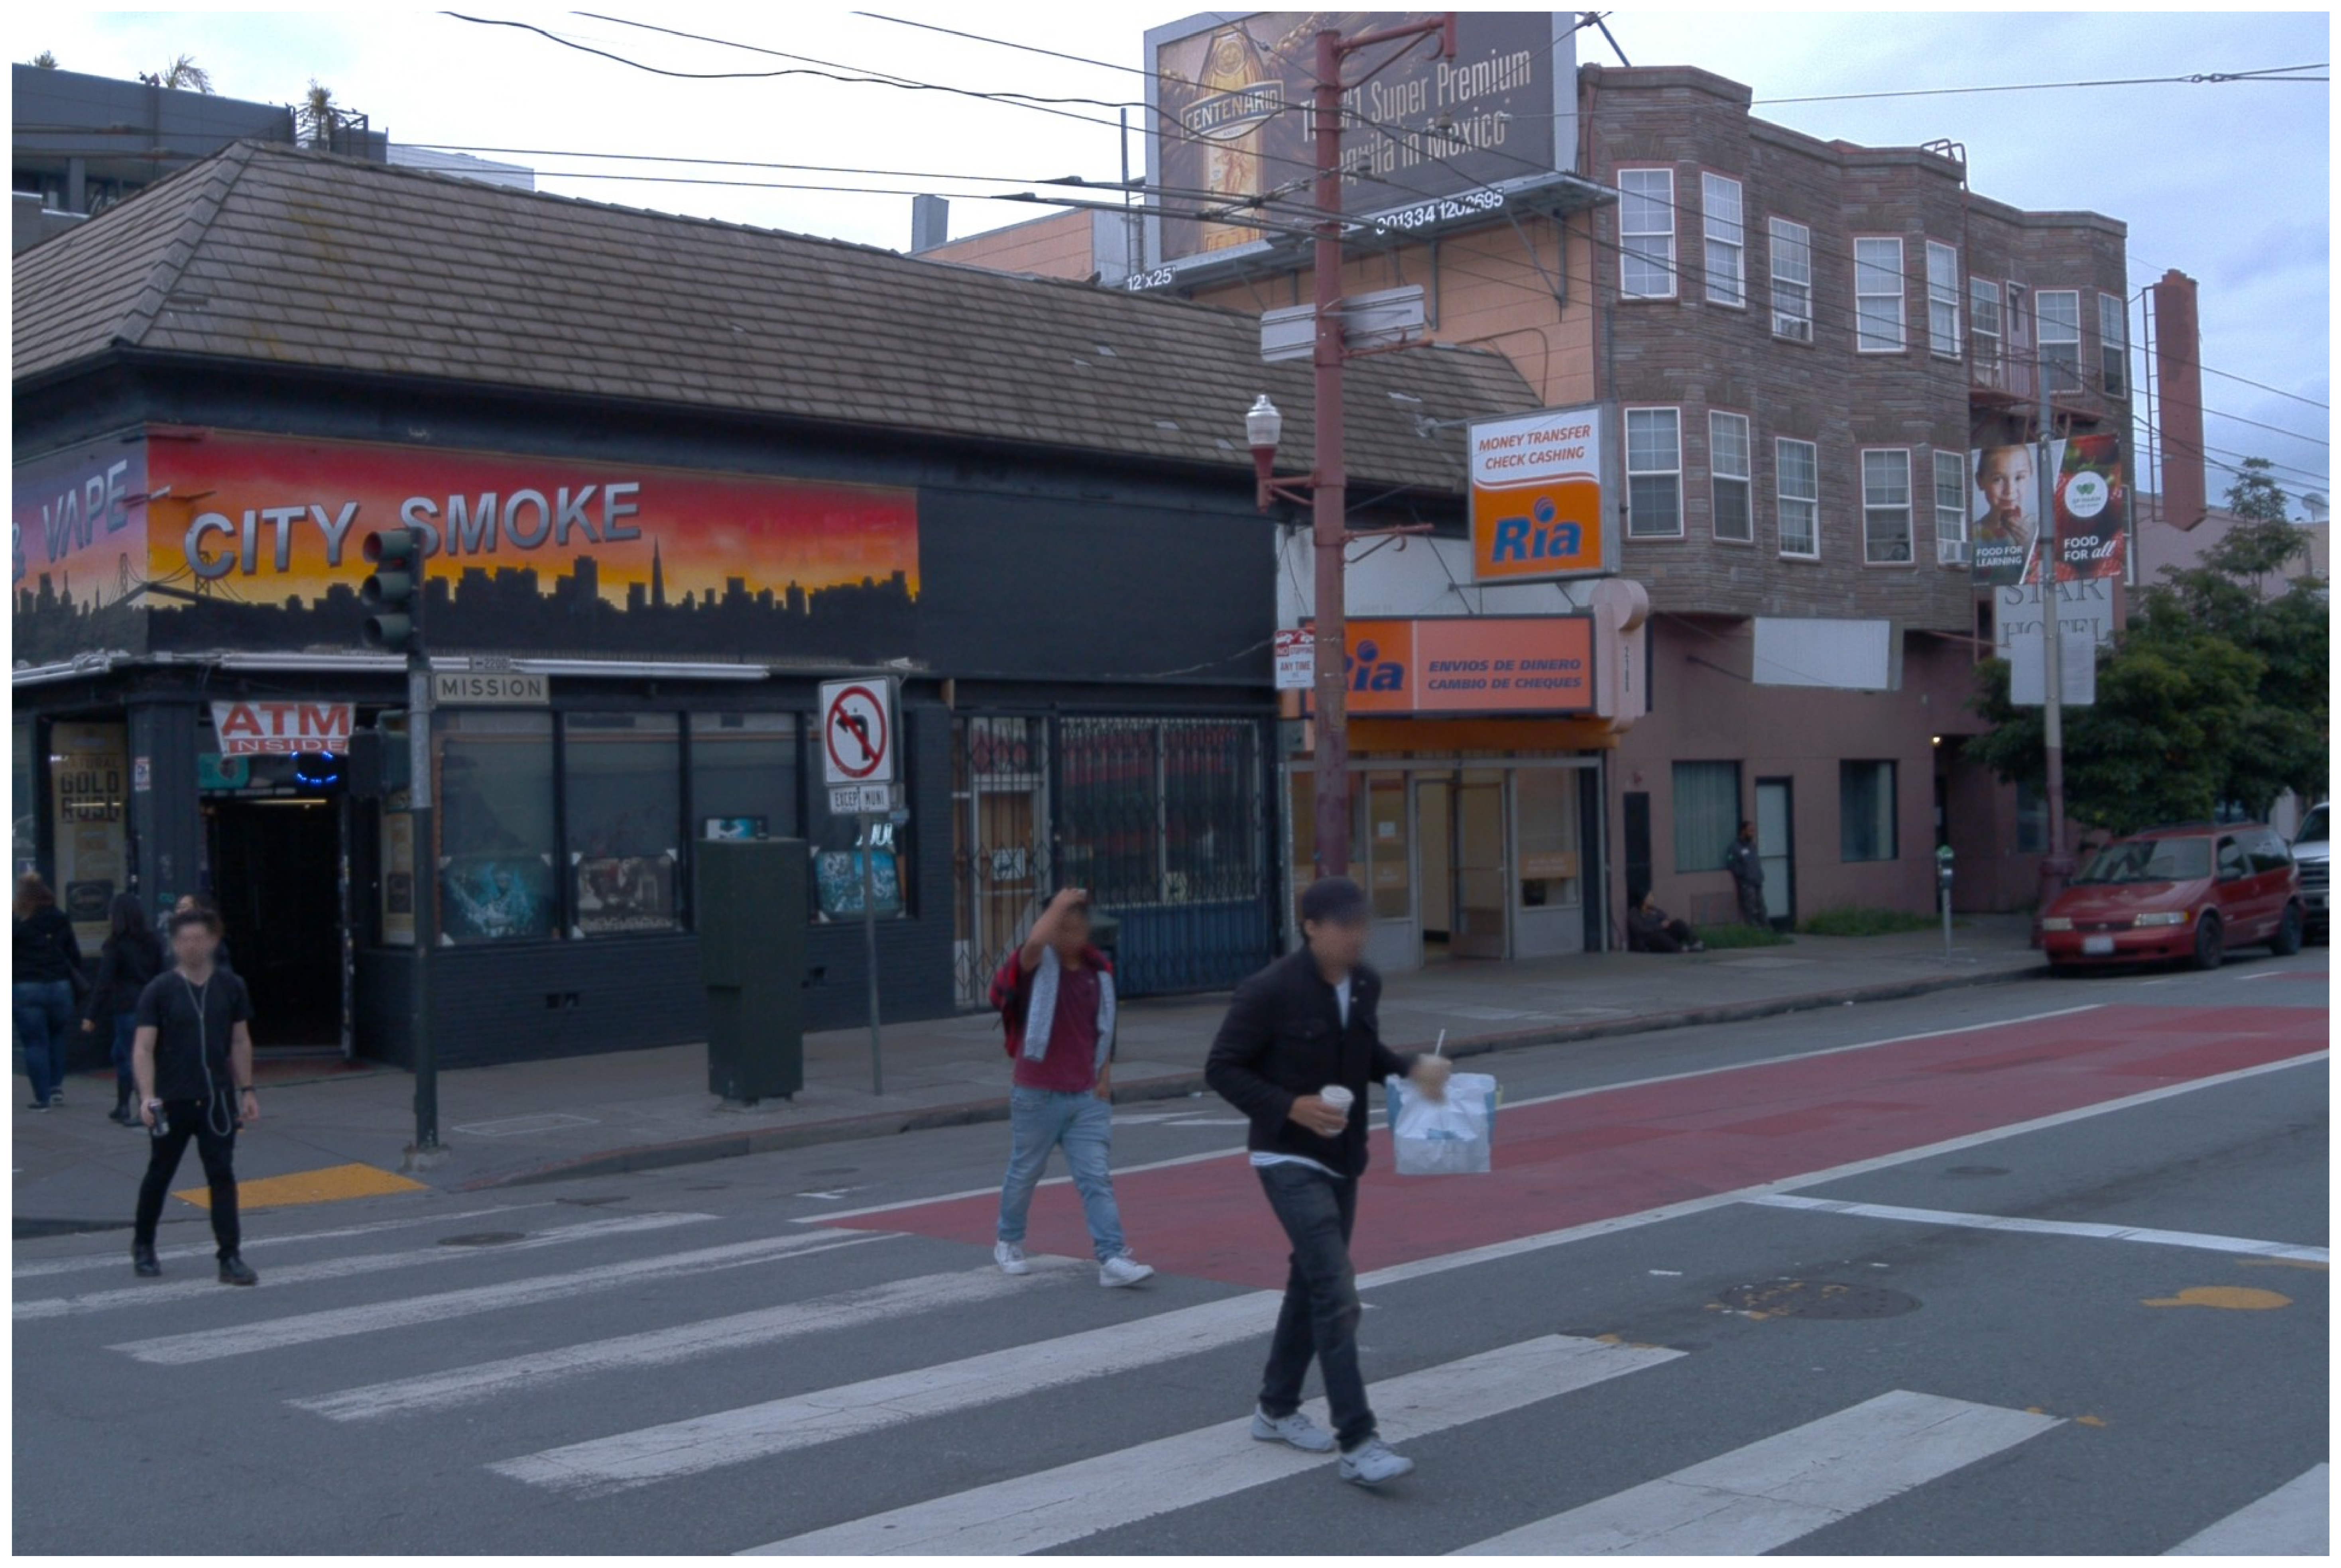

In [490]:


def _imdecode(buf: bytes):
    with io.BytesIO(buf) as fd:
        pil = PIL.Image.open(fd)
        return np.array(pil)

def _imshow(ax: plt.Axes, image_np: np.ndarray):
    # image_np = cv2.copyMakeBorder(image_np, top=250, bottom=250, left=250, right=250, borderType=cv2.BORDER_CONSTANT)
    ax.imshow(image_np)
    ax.axis('off')
    ax.set_autoscale_on(False)

camera_image_by_name = {i.name: i.image for i in frame.images}
image_np = _imdecode(camera_image_by_name[cam])
keypoint_draw.OCCLUDED_BORDER_WIDTH = 3
_, ax = plt.subplots(frameon=False, figsize=(25, 25))
_imshow(ax, image_np)
#keypoint_draw.draw_camera_wireframe(ax, camera_wireframe_complete)
plt.show()



In [491]:
JOINT_NAMES = ["NOSE", "LEFT_SHOULDER", "LEFT_ELBOW",
               "LEFT_WRIST", "LEFT_HIP", "LEFT_KNEE",
               "LEFT_ANKLE", "RIGHT_SHOULDER", "RIGHT_ELBOW",
               "RIGHT_WRIST", "RIGHT_HIP", "RIGHT_KNEE", "RIGHT_ANKLE"]

occlusions_scores

for name, score in zip(JOINT_NAMES, occlusions_scores):
    print(f"{name}: {score}")


NOSE: 0.9002402424812317
LEFT_SHOULDER: 0.9063296914100647
LEFT_ELBOW: 0.8855839967727661
LEFT_WRIST: 0.9570556879043579
LEFT_HIP: 0.862960696220398
LEFT_KNEE: 0.9128527641296387
LEFT_ANKLE: 0.9118770360946655
RIGHT_SHOULDER: 0.9260107278823853
RIGHT_ELBOW: 0.5647789239883423
RIGHT_WRIST: 0.6991184949874878
RIGHT_HIP: 0.872089684009552
RIGHT_KNEE: 0.9011104702949524
RIGHT_ANKLE: 0.9336627125740051


(463, 190, 3)
[Dot(location=array([106.42874475,  94.71280015]), color='#00FF00', size=1.4579439252336448, name='NOSE', border_color=None), Dot(location=array([120.34347864, 136.45694078]), color='#FFA6FE', size=4.429906542056075, name='LEFT_SHOULDER', border_color=None), Dot(location=array([124.98172327, 187.47757066]), color='#FFE502', size=4.037383177570093, name='LEFT_ELBOW', border_color=None), Dot(location=array([124.98172327, 219.94528306]), color='#006401', size=3.4766355140186915, name='LEFT_WRIST', border_color=None), Dot(location=array([111.06698938, 233.85995591]), color='#010067', size=6.0, name='LEFT_HIP', border_color=None), Dot(location=array([120.34347864, 308.07180894]), color='#95003A', size=4.878504672897196, name='LEFT_KNEE', border_color=None), Dot(location=array([134.25821252, 373.00717271]), color='#007DB5', size=4.990654205607477, name='LEFT_ANKLE', border_color=None), Dot(location=array([ 64.68460412, 131.81869615]), color='#774D00', size=4.429906542056075, na

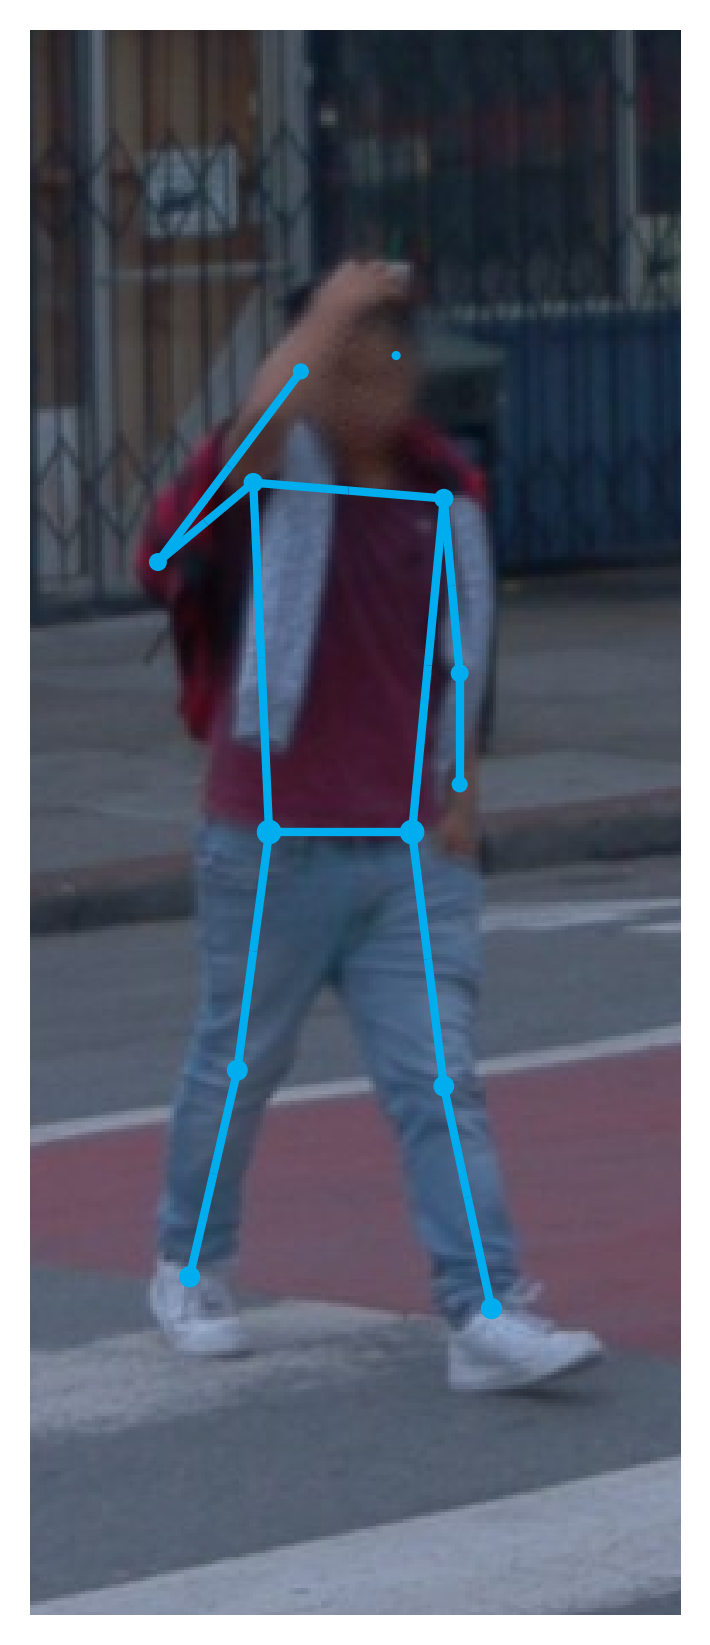

<Figure size 1800x1200 with 0 Axes>

In [492]:
import cv2

croped_image, _ = keypoint_draw.crop_camera_keypoints(
    image_np,
    obj_labels.camera[cam].keypoints.keypoint,
    obj_labels.camera[cam].box,
    margin=0.3)
print(croped_image.shape)
white_img = np.ones(croped_image.shape)
_, ax = plt.subplots(frameon=False, figsize=(5, 7))
#croped_image = np.ones((500,200,3))*0
_imshow(ax, croped_image)
draw_camera_wireframe(ax, camera_wireframe_cropped,zorders=(1,2), alpha=1,color='#00ADEF')
print(croped_image.shape)
plt.show()
plt.savefig("mpjpe_pred.png", bbox_inches="tight", transparent=True)

In [493]:
# show laser keypoints of tfr-file
import plotly.graph_objects as go

def _draw_laser_points(fig: go.Figure,
                       points: np.ndarray,
                       color: str = 'gray',
                       size: int = 3):
  """Visualizes laser points on a plotly figure."""
  fig.add_trace(
      go.Scatter3d(
          mode='markers',
          x=points[:, 0],
          y=points[:, 1],
          z=points[:, 2],
          marker=dict(color=color, size=size)))

def _create_plotly_figure() -> go.Figure:
    """Creates a plotly figure for 3D visualization."""
    fig = go.Figure()
    axis_settings = dict(
        showgrid=False,
        zeroline=False,
        showline=False,
        showbackground=False,
        showaxeslabels=False,
        showticklabels=False)
    fig.update_layout(
        width=600,
        height=600,
        showlegend=False,
        scene=dict(
            aspectmode='data',  # force xyz has same scale,
            xaxis=axis_settings,
            yaxis=axis_settings,
            zaxis=axis_settings,
        ),
    )
    return fig


from waymo_open_dataset.utils import  frame_utils
from waymo_open_dataset.utils import box_utils

(range_images, camera_projections, _, range_image_top_pose
) = frame_utils.parse_range_image_and_camera_projection(frame)
points, cp_points = frame_utils.convert_range_image_to_point_cloud(
    frame, range_images, camera_projections, range_image_top_pose)
points_all = np.concatenate(points, axis=0)
box = box_utils.box_to_tensor(obj_labels.laser.box)[tf.newaxis, :]
box_points = points_all[box_utils.is_within_box_3d(points_all, box)[:, 0]]
print(f'{box_points.shape[0]} laser points selected.')

# Select laser points inside pedestrian's bounding box
if len(obj_labels.laser.keypoints.keypoint)>0:

    # Visualize 3D scene
    laser_wireframe = keypoint_draw.build_laser_wireframe(
        obj_labels.laser.keypoints.keypoint)
    fig = _create_plotly_figure()
    keypoint_draw.draw_laser_wireframe(fig, laser_wireframe)
    _draw_laser_points(fig, box_points)
else:
    fig = _create_plotly_figure()
    _draw_laser_points(fig, box_points)
fig.show()

448 laser points selected.


#  Overlay of Alpha Pose and normal label

In [494]:
import pandas as pd
path = "/media/petbau/data/waymo/v0.10/3D_2D/"
image_segment_relations_gt = pd.read_csv (path + "image_segment_relations.csv")


import pickle
# load the labels file
with open(path + "labels.pkl", 'rb') as pickle_file:
    labels_gt = pickle.load(pickle_file)
    

[Dot(location=array([130.321176 , 369.7885298]), color='#007DB5', size=4.990654205607477, name='LEFT_ANKLE', border_color=None), Dot(location=array([ 63.6715886, 129.1716875]), color='#774D00', size=4.429906542056075, name='RIGHT_SHOULDER?', border_color='#000000'), Dot(location=array([ 66.8232227, 117.771488 ]), color='#90FB92', size=4.037383177570093, name='RIGHT_ELBOW', border_color=None), Dot(location=array([123.9968548, 131.6012037]), color='#FFA6FE', size=4.429906542056075, name='LEFT_SHOULDER', border_color=None), Dot(location=array([128.8411501, 182.7010453]), color='#FFE502', size=4.037383177570093, name='LEFT_ELBOW?', border_color='#000000'), Dot(location=array([127.0116444, 226.7712902]), color='#006401', size=3.4766355140186915, name='LEFT_WRIST', border_color=None), Dot(location=array([90.5752173, 80.549784 ]), color='#0076FF', size=3.4766355140186915, name='RIGHT_WRIST', border_color=None), Dot(location=array([ 71.814889 , 230.3124048]), color='#D5FF00', size=6.0, name='R

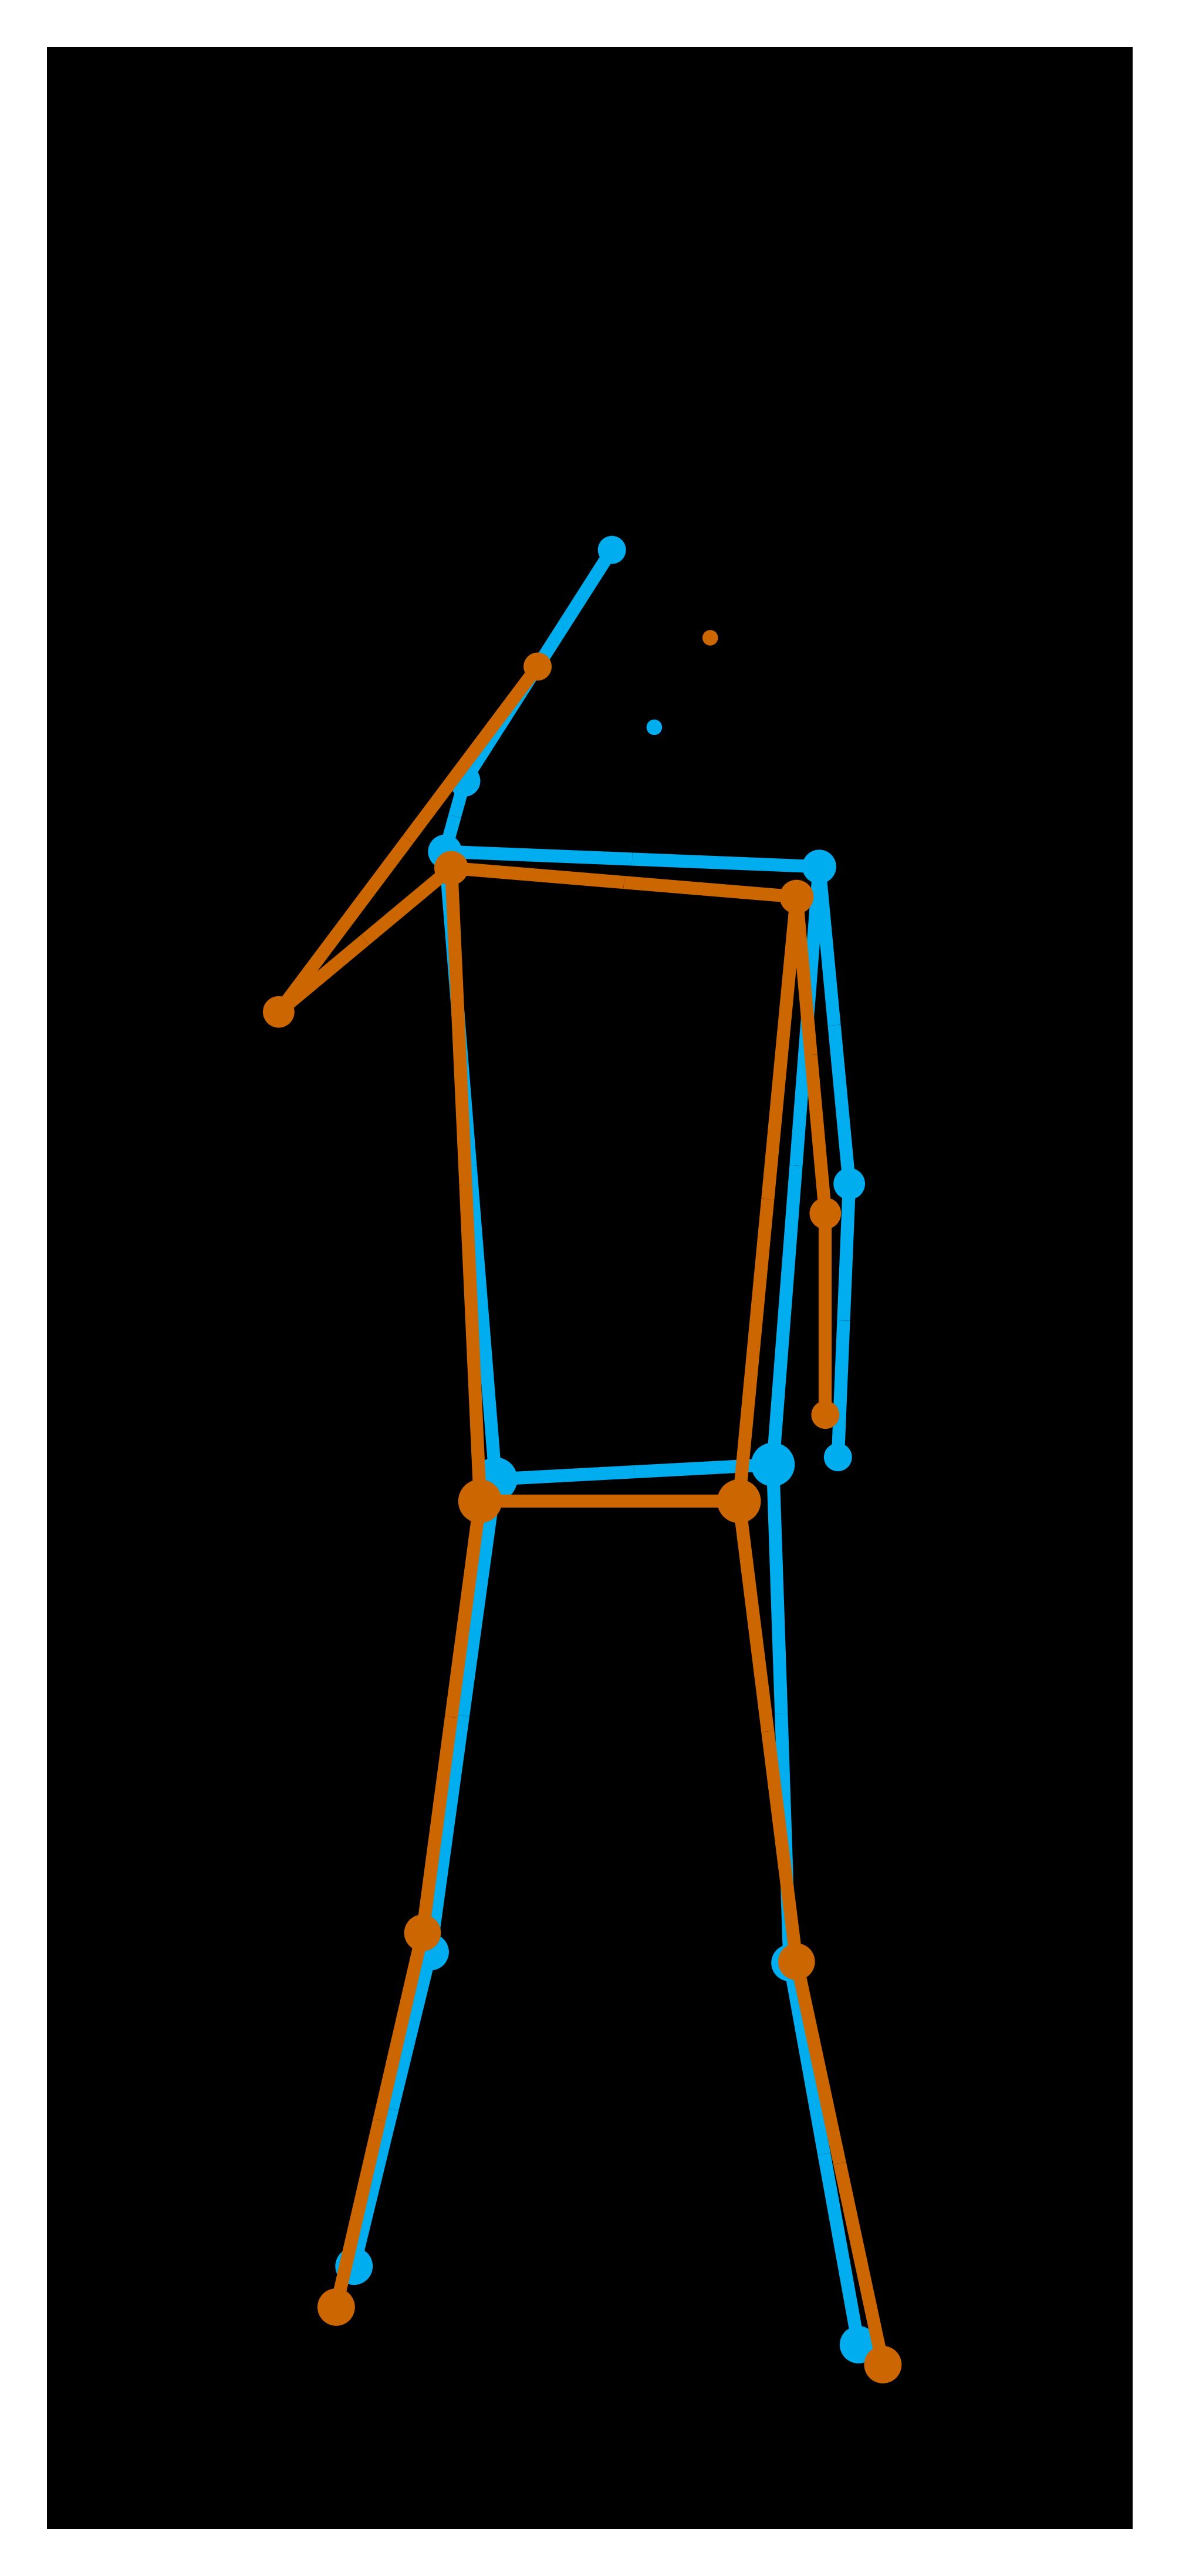

In [499]:
# waymo_open_dataset.protos.keypoint_pb2.CameraKeypoint
import numpy as np
from waymo_open_dataset.protos import keypoint_pb2
from waymo_open_dataset.utils import keypoint_draw

def _imshow(ax: plt.Axes, image_np: np.ndarray):
  # image_np = cv2.copyMakeBorder(image_np, top=250, bottom=250, left=250, right=250, borderType=cv2.BORDER_CONSTANT)
  ax.imshow(image_np)
  ax.axis('off')
  ax.set_autoscale_on(False)


cropped_camera_keypoints = []
counter = 0
for keypoint in labels_gt[id]['keypoints_2d']:
    if keypoint != 19:
        cam_keypoint = keypoint_pb2.CameraKeypoint()
        cam_keypoint.type = keypoint
        cam_keypoint.keypoint_2d.location_px.x = labels_gt[id]['keypoints_2d'][keypoint]['x']
        cam_keypoint.keypoint_2d.location_px.y = labels_gt[id]['keypoints_2d'][keypoint]['y']
        cam_keypoint.keypoint_2d.visibility.is_occluded =  labels_gt[id]['keypoints_2d'][keypoint]['occluded']
        cropped_camera_keypoints.append(cam_keypoint)


camera_wireframe = keypoint_draw.build_camera_wireframe(
    cropped_camera_keypoints)

img = np.ones((400,175,3))*0
keypoint_draw.OCCLUDED_BORDER_WIDTH = 3
_, ax = plt.subplots(frameon=False, figsize=(5, 7))
_imshow(ax, img)
# GT IS BLUE 
draw_camera_wireframe(ax, camera_wireframe,  zorders=(1,2), alpha=1 ,color='#00ADEF')
plt.savefig("mpjpe_GT.png", bbox_inches="tight", transparent=True)

draw_camera_wireframe(ax, camera_wireframe_cropped, zorders=(3,4), alpha=1, color="#CC6600")


plt.savefig("mpjpe_overlay.png", bbox_inches="tight", transparent=True)
print(img.shape)
plt.show()
